## Tutorial

This simple guide can help you start working with Tree-AMP.

### Building your first model

#### Creating a variable

Let us start by creating our first variable `tramp.variables.SISOVariable` `V` of size `N` drawn from a `priors.GaussBernoulliPrior` separable prior with sparsity `rho`

In [1]:
from tramp.variables import SISOVariable as V
from tramp.priors import GaussBernoulliPrior
N, rho = 100, 0.1
prior = GaussBernoulliPrior(size=N, rho=rho)
var_x = prior @ V("x")

The opeartor `@` allows to assign a variable `x` drawn from a `prior` distribution, and in general to concatenate modules together.

# Draw a matrix from an ensemble

Creating a matrix `W` instance of the `tramp.ensembles.GaussianEnsemble` of size `M x N` can be done by

In [2]:
from tramp.ensembles import GaussianEnsemble
M, N = 200, 100
ensemble = GaussianEnsemble(M, N)
W = ensemble.generate()

# Constructing a linear channel

The variable `x` can be mutliplied by the matrix `W` using the `channels.LinearChannel`.
The result can be casted in a new variable `z0 = W x` with `W ~ ensemble` and `x ~  prior`.

In [3]:
from tramp.channels import LinearChannel
model = prior @ V("x") @ LinearChannel(W=W, name='W') @ V("z0")

# Adding other modules

As many module as desired can be added to the previous `model`. Each module must be followed by a variable `V`.
For example a `tramp.channels.BiasChannel` with value `b` with intermediate variabel `z`,
followed by a `tramp.channels.ReluChannel` outputing a variable `h`.

In [4]:
from tramp.channels import BiasChannel, ReluChannel
b = 0.1
model = model @ BiasChannel(bias=b) @ V("z")
model = model @ ReluChannel() @ V("h")

# Adding observations

Observations `tramp.SILeafVariable` `O` can be added to the the `model`.
For example `model` may go through a noisy `tramp.channels.GaussianChannel` with variance `var` and outputs a variable `y`

In [5]:
from tramp.variables import SILeafVariable as O
from tramp.channels import GaussianChannel
var = 1e-2
model = model @ GaussianChannel(var=var) @ O("y")

# Representing the model

Once the model completed, it can be built with the method `.to_model()` and drawn with `.plot()` :

In [6]:
model = model.to_model()
model.plot()

EP/SE in the Bayes-optimal scenario

Let us illustrate how to run `EP` or `SE` in the Bayes-optimal case and on a more complex model: a sparse gradient prior.

# Build the model

Creating a variable `x` of size `N` sampled from a `tramp.priors.GaussianPrior` with  `n_next=2` successors can be done with a `tramp.variables.SIMOVariable` `V`

In [7]:
from tramp.variables import SIMOVariable as V
from tramp.priors import GaussianPrior
N = 100
prior_x = GaussianPrior(size=N, var=1) @ V(id="x", n_next=2)

which can be connected to a `tramp.channels.GaussianChannel` with `y` observations and a sparse gradient constraint on `x`.
This constraint can be built with a new variable `x'` connected to `n_prev=2` predecesors: a `tramp.channels.GradientChannel` connected to `x` and a `tramp.priors.GaussBernoulliPrior` with sparsity `rho`.

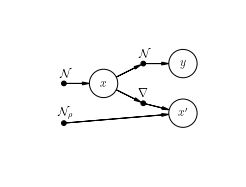

In [8]:
from tramp.channels import GradientChannel, GaussianChannel
from tramp.priors import GaussBernoulliPrior
from tramp.variables import SISOVariable as V, MILeafVariable
rho = 0.04
var = 0.1
x_shape = (N,)
grad_shape = (1,) + x_shape
# Create the gaussian channel and the observations y
channel_y = GaussianChannel(var=var) @ O("y")
# Create the sparse gradient constraint and the new variable x'
channel_grad = (GradientChannel(shape=x_shape) + GaussBernoulliPrior(size=grad_shape, rho=rho)) @ MILeafVariable(id="x'", n_prev=2)
# Plug the two channels to the variables x
model = prior_x @ ( channel_y +  channel_grad )
# Build the model
model = model.to_model()
# Show the model
model.plot()

# Teacher-Student scenario

In a `tramp.experiments.BayesOptimalScenario`, ground truth samples of all the variables contained in the `model` are drawn (namely `x, x', y` ).
The `scenario` tries then to infer the variables `x_ids` from the observations `y` and knowing the structure and the parameters of the model (`rho`, `var`).
The `scenario` is setup with a `.setup()` method where an optional `seed` can be used for reproducibility.

In [9]:
from tramp.experiments import BayesOptimalScenario
x_ids = ["x", "x'"]
scenario = BayesOptimalScenario(model, x_ids=x_ids)
scenario.setup(seed=42)

# Run Expectation Propagation (EP)

EP can be run on the above `scenario` with the method `.run_ep()`.
Optional maximum number of iterations `max_iter` and `damping` on all variables to help convergence can be added.
Different `callback` can be used such as `tramp.algos.EarlyStoppingEP` if precision `tol` is reached.

In [10]:
from tramp.algos import EarlyStoppingEP
scenario.run_ep(max_iter=1000, damping= 0.1, callback=EarlyStoppingEP(tol=1e-2))

{'x': {'shape': (100,),
  'r': array([ 0.27857645,  0.32598936,  0.3064793 ,  2.04296751,  0.27643067,
         -0.06356004, -0.06242686,  0.01897334,  0.05411335,  0.05313281,
          0.05451164,  0.06082305, -0.69834281, -0.69338039, -0.5389696 ,
         -0.07462601, -0.08064977, -0.09949704, -0.06818961, -0.06719108,
         -0.07062447, -0.05477488, -0.05384834, -0.06384254,  0.07644415,
          0.17729012,  0.91596791,  0.91798001, -0.88833409, -0.88263299,
          0.61071153,  0.60916758,  0.6157695 ,  3.0289879 ,  0.87687559,
          0.88806585,  0.89426002,  0.87982258,  0.39816488,  0.47653595,
         -0.22448448, -0.16867378, -0.13906378, -0.12016692,  1.73137042,
         -0.84400041, -0.3886366 , -0.39572171, -0.3866281 ,  0.02210296,
          0.02277681, -0.14489049, -0.14210067, -0.10970182, -0.18294118,
         -0.18550899, -0.19088093, -0.21473754,  1.8959058 ,  0.475709  ,
         -1.72894287, -0.10378992, -0.10426969, -0.08692119, -0.10228154,
         

To use multiple callbacks at a time, you need to use `tramp.algos.JoinCallback`:

In [11]:
from tramp.algos import JoinCallback, EarlyStoppingEP, TrackOverlaps, TrackEstimate
track_overlap = TrackOverlaps(true_values=scenario.x_true)
track_estimate = TrackEstimate()
callback = JoinCallback([track_overlap, track_estimate, EarlyStoppingEP(tol=1e-12)])

# Run State Evolution (SE)

SE can be performed simply with the `run_se()` method

In [12]:
scenario.run_se()

{'x': {'shape': (100,), 'tau': 1, 'v': 0.008372985084226197},
 "x'": {'shape': (1, 100), 'tau': 2.0, 'v': 0.0028245543549972685},
 'n_iter': 20}